# Introduction to machine learning: Decision makings -- Active learning with microRNA Classification

In this notebook, we illustrate the classification task on microRNA data and show active learning methods. We will go through: 

* Mirtron
* Logistic regression
* Active learning
    * uncertainty sampling 
    * least confidence sampling

In [12]:
import csv
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np 
import random as python_random
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import math
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, auc, roc_curve, matthews_corrcoef, precision_recall_curve
from sklearn.linear_model import LogisticRegression

In [2]:
# To obtain reproducible result
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

## Mirtron Data 

What is MicroRNA:
> from wiki: *MicroRNAs (miRNAs) are a class of non-coding RNAs that play important roles in regulating gene expression. The majority of miRNAs are transcribed from DNA sequences into primary miRNAs and processed into precursor miRNAs, and finally mature miRNAs.*

What is Mirtron: 
> from wiki: *Mirtrons are a type of microRNAs that are located in the introns of the mRNA encoding host genes. These short hairpin introns formed via atypical miRNA biogenesis pathways. Mirtrons arise from the spliced-out introns and are known to function in gene expression.*

data: https://github.com/rorbachg/Mirtrons/tree/master/Data

In [3]:
miRBase_df = pd.read_csv( "data/data.csv")
print(miRBase_df.shape)
miRBase_df.head()

(923, 10)


,Unnamed: 0,hairpin_name,hairpin_seq,dotbracket,fe,arm5p,mature5p_seq,arm3p,mature3p_seq,class
0,1,hsa-let-7a-1,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,(((((.(((((((((((((((((((((.....(((...((((.......,-34.2,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,False
1,2,hsa-let-7a-2,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...,(((..(((.(((.(((((((((((((.........(((......))...,-25.2,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-2-3p,CUGUACAGCCUCCUAGCUUUCC,False
2,3,hsa-let-7a-3,GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...,(((.(((((((((((((((((((((((((((...)))))).........,-34.1,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,False
3,4,hsa-let-7b,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCC...,(((((.(((((((((((((((((((((((.((((((.....)))))...,-46.7,hsa-let-7b-5p,UGAGGUAGUAGGUUGUGUGGUU,hsa-let-7b-3p,CUAUACAACCUACUGCCUUCCC,False
4,5,hsa-let-7c,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCU...,((.((((((..(((.(((.(((((((((((((..((.(..((...)...,-31.6,hsa-let-7c-5p,UGAGGUAGUAGGUUGUAUGGUU,hsa-let-7c-3p,CUGUACAACCUUCUAGCUUUCC,False


### Helper functions

First, we convert the hairpin_seq into K-mers, which are short subsequences of length k that are extracted from longer sequences, such as DNA or protein sequences. In bioinformatics, k-mers are commonly used to represent and analyze sequence data. The value of k determines the length of each subsequence.

In [4]:
def kmers_builder(sequences, ksize):
    kmers = []
    for seq in sequences:
        n_kmer = len(seq) - ksize + 1
        kmer = []
        for i in range(n_kmer):
            temp_kmer = seq[i:i + ksize]
            kmer.append(temp_kmer)
        kmers.append(kmer)
    return kmers

kmers_builder(['AGGUUG'],2)

[['AG', 'GG', 'GU', 'UU', 'UG']]

Then we convert kmers into onehot encoding:
One-hot encoding is a technique used to represent categorical variables as binary vectors. It is commonly employed in machine learning and data analysis tasks where categorical features need to be transformed into a numerical representation that algorithms can understand.

Here's an example of how one-hot encoding can be applied to DNA sequences:

Consider the DNA sequence "ACTG". Each character (nucleotide base) in the sequence is a category. To one-hot encode this sequence, we assign a binary vector representation to each base:

* Adenine (A): [1, 0, 0, 0]
* Cytosine (C): [0, 1, 0, 0]
* Guanine (G): [0, 0, 1, 0]
* Thymine (T): [0, 0, 0, 1]

In [6]:
def one_hot_encoding(sequences, k_mer):
    encoded_data = []
    n = len(sequences)
    l = len(sequences[0])
    for i in range(n):
        data = []
        for k in range(l):
            seq = sequences[i][k]
            letter = [0 for _ in range(4**k_mer)]
            if seq == 0:
                data.append(letter)
            else:    
                index = seq-1
                letter[index] = 1
                data.append(letter)
        encoded_data.append(data)
    
    return np.array(encoded_data)

We also add evalaution method to evaluate the predictions from our model.
1. Recall (Sensitivity): Recall measures the ability of a classification model to identify all positive instances correctly. It calculates the ratio of true positives to the sum of true positives and false negatives. In other words, it tells us how well the model identifies the positive cases among all the actual positive cases.

2. Specificity: Specificity measures the ability of a classification model to correctly identify negative instances. It calculates the ratio of true negatives to the sum of true negatives and false positives. Specificity provides information about how well the model identifies the negative cases among all the actual negative cases.

3. Area Under the Curve (AUC): AUC refers to the area under the Receiver Operating Characteristic (ROC) curve. The ROC curve represents the trade-off between the true positive rate (sensitivity) and the false positive rate. AUC provides a single value that represents the overall performance of a classification model. A higher AUC indicates better discrimination between positive and negative instances.

4. F1 Score: F1 score is a measure of the model's accuracy by considering both precision and recall. It is the harmonic mean of precision and recall and provides a balanced evaluation metric. F1 score ranges from 0 to 1, with 1 being the best performance.

5. Matthews Correlation Coefficient (MCC): MCC is a metric that takes into account true positives, true negatives, false positives, and false negatives. It is particularly useful when dealing with imbalanced datasets. MCC ranges from -1 to +1, where +1 indicates a perfect prediction, 0 indicates random prediction, and -1 indicates a complete disagreement between predictions and actual labels.

In [7]:
def evaluating(round_test, round_pre):
    
    # Confusion matrix
    c = confusion_matrix(round_test, round_pre)

    # Precision 
    p = precision_score(round_test, round_pre)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(round_test, round_pre).ravel()
    s =  tn / (tn+fp)

    # AUC
    fpr, tpr, _ = roc_curve(round_test, round_pre)
    auc_score = auc(fpr, tpr)

    model_precision, model_recall, _ = precision_recall_curve(round_test, round_pre)
    pr_auc_score = auc(model_recall, model_precision)

    # Recall
    r = recall_score(round_test, round_pre)

    # Accuracy
    a = accuracy_score(round_test,round_pre)

    # F1 score
    f1 = f1_score(round_test,round_pre)

    # MCC
    mcc = matthews_corrcoef(round_test, round_pre)

    # cohen kappa score
    cks = cohen_kappa_score(round_test,round_pre)

    result_dic = {
      'Recall': r,
      'Specificity': s,
      'AUC': auc_score,
      'F-1': f1,
      'Matthews Corrcoef': mcc
    }
    return result_dic

# Classification with Logistic Regression

Scikit-learn provides a straightforward and efficient implementation of logistic regression, a popular classification algorithm. By importing the LogisticRegression class from the sklearn.linear_model module, we can create an instance of the logistic regression model. We can then use the fit() method to train the model on our dataset, passing in the feature matrix and corresponding target labels. During the training process, scikit-learn optimizes the model's parameters using an appropriate solver, such as the default 'lbfgs' solver

In [8]:
# df = mirtron_df.append(putative_mirtron_df,ignore_index=True)
# df = df.append(canonical_miRNA_df, ignore_index=True)

k_mer = 2
max_len = 80
miRNA_seq = miRBase_df["hairpin_seq"]
miRNA_kmer = kmers_builder(miRNA_seq, k_mer)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(miRNA_kmer)
vocab_size = len(tokenizer.word_index)

In [13]:
X = tokenizer.texts_to_sequences(miRNA_kmer)
X = one_hot_encoding(pad_sequences(X, maxlen=max_len, padding='pre',truncating='pre'), k_mer) 
X = X.reshape(X.shape[0],-1)

miRBase_df.loc[miRBase_df["class"]==True,"class"] = 1
miRBase_df.loc[miRBase_df["class"]==False,"class"] = 0
y = list(miRBase_df["class"])

In [14]:
# Split the dataset into train and test sets (80% for train + val, 20% for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Print the shape of each set
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (738, 1280)
Test set shape: (185, 1280)


<div class="alert alert-block alert-warning">
<b>TODO: Fit the logistic regression model on the training data. Make predictions (y_pred) on the test data and evalaute using the helper function above.
</b>
</div>

In [16]:
# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
evaluating(y_test, y_pred)

{'Recall': 0.7777777777777778,
 'Specificity': 0.9664429530201343,
 'AUC': 0.872110365398956,
 'F-1': 0.8115942028985507,
 'Matthews Corrcoef': 0.7696041202222679}

## Active Learning 

Now we move to an active learning setting, where we have a small part of data for pretrain, a pool of data for active/sequential querying, and then test how our model would performance on the test data. We test the uncertainty sampling methods (entrop, least confidence) and compare with random sampling. 

In [17]:
# pre-train/val/test: 10/70/20

# Split the dataset into train and test sets (80% for train + val, 20% for test)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the trainval set into train and validation sets (12.5% for val, 70% for train)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.92, random_state=42)

In [18]:
# Print the shape of each set
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (59, 1280)
Validation set shape: (679, 1280)
Test set shape: (185, 1280)


In [19]:
# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
evaluating(y_test, y_pred)

{'Recall': 0.3333333333333333,
 'Specificity': 0.9932885906040269,
 'AUC': 0.6633109619686801,
 'F-1': 0.489795918367347,
 'Matthews Corrcoef': 0.5058873475194424}

Define active learning loop in the following, 

<div class="alert alert-block alert-warning">
<b>TODO: your task is to fill in the two active learning uncertainty sampling policies (entropy, least confidence)
</b>
</div>

As a reminder:
    
* Entropy: information-theoretic measure that represents the amount of information needed to “encode” a distribution
$$x_{E N T}^*=\underset{x}{\operatorname{argmax}}-\sum_i P\left(y_i \mid x ; \theta\right) \log P\left(y_i \mid x ; \theta\right)$$

* Least confidence: select the data point which we are predicting with least confidence
$$x_{L C}^*=\underset{x}{\operatorname{argmin}} P\left(y^* \mid x ; \theta\right)$$
where $y^*=\operatorname{argmax}_y P(y \mid x ; \theta)$.

In [20]:
def AL_loop(X_train, y_train, X_val, y_val, X_test, y_test, policy = 'random', round = 100):
    queries = []

    pool_X = X_val.copy()
    pool_y = y_val.copy()

    new_X = X_train.copy()
    new_y = y_train.copy()
    
    auc_scores = []

    for i in range(round):
        
        model = LogisticRegression()
        model.fit(new_X, new_y)
        
        y_pred = model.predict(X_test)

        score_dict = evaluating(y_test, y_pred)
        auc_scores.append(score_dict['AUC'])

        prob_dist = model.predict_proba(pool_X)
        
        if policy == 'entropy':
            log_probs = prob_dist * np.log2(prob_dist) 
            raw_entropy = 0 - np.sum(log_probs, axis=1)  
            select_idx = np.argmax(raw_entropy)
        elif policy == 'leastconfidence':
            simple_least_conf = np.max(prob_dist,axis =1) # most confident prediction
            select_idx = np.argmin(simple_least_conf)
        elif policy == 'random':
            np.random.seed(0)
            select_idx = np.random.choice(range(len(pool_X)))
        else:
            return NotImplementedError
        
        new_X = np.append(new_X,[pool_X[select_idx]], axis = 0)
        new_y.append(pool_y[select_idx]) 
        
        pool_X = np.delete(pool_X, select_idx, axis = 0)
        pool_y = np.delete(pool_y, select_idx, axis = 0)
        # print(len(X_val))
    return auc_scores

In [21]:
# entropy
from collections import defaultdict

eva_dict = defaultdict(list) # key: policy; value: AUC score list
policy_list = ['entropy', 'leastconfidence', 'random']
# round_list = [1, 50, 100, 150, 200, 250, 300, 350, 400]
round = 200

for policy in policy_list:
    eva_dict[policy] = AL_loop(X_train, y_train, X_val, y_val, X_test, y_test, policy, round = round)

Text(0, 0.5, 'AUC score')

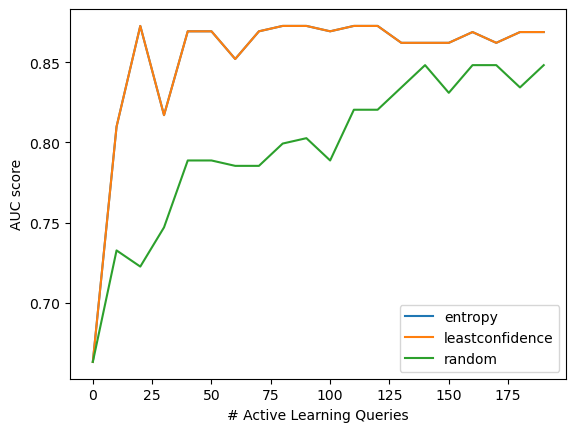

In [22]:
for policy in policy_list:
    plt.plot(range(round)[::10], eva_dict[policy][::10], label = policy)
plt.legend()
plt.xlabel("# Active Learning Queries")
plt.ylabel("AUC score")